In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Import Library

In [ ]:
import os
import re
import requests
import zipfile
import io
import codecs
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, LSTM, Bidirectional
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

###Load Dataset

In [ ]:
path = '/content/drive/My Drive/Chatbot LSTM/kamusdata.txt'

###Text Preprocessing

In [ ]:
import re
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')  # Unduh corpus WordNet untuk lemmatisasi (lakukan sekali saat pertama kali)
lemmatizer = WordNetLemmatizer()


def get_all_conversations(path):
    all_conversations = []
    with open(path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        for line in lines:
            # Pisahkan pertanyaan dan jawaban menggunakan tanda koma
            question, answer = line.strip().split('\t')
            all_conversations.append((question, answer))
    return all_conversations

def clean_text(text_to_clean):
    text = text_to_clean.lower()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    cleaned_text = ' '.join(lemmatized_words)

    return cleaned_text

def get_clean_q_and_a(conversations):
    ctx_and_target = []
    for question, answer in conversations:
        # Bersihkan pertanyaan dan jawaban serta tambahkan token <START> dan <END>
        cleaned_question = clean_text(question)
        cleaned_answer = '<START> ' + clean_text(answer) + ' <END>'
        ctx_and_target.append((cleaned_question, cleaned_answer))
    # zip dengan * operator untuk memisahkan pertanyaan dan jawaban
    context, target = zip(*ctx_and_target)
    return list(context), list(target)

# Path ke file dataset
path = '/content/drive/My Drive/Chatbot LSTM/kamusdata.txt'

# Dapatkan semua percakapan dari file
all_conversations = get_all_conversations(path)

# Bersihkan pertanyaan dan jawaban serta tambahkan token <START> dan <END>
cleaned_questions, cleaned_answers = get_clean_q_and_a(all_conversations)

# Cetak hasil
print("Pertanyaan Bersih:", cleaned_questions[:5])
print("Jawaban Bersih:", cleaned_answers[:5])


Pertanyaan Bersih: ['halo', 'hai', 'selamat pagi', 'assalamualaikum', 'selamat pagi']
Jawaban Bersih: ['<START> halo! apa yang bisa saya bantu? <END>', '<START> hai, kamu butuh bantuan apa? <END>', '<START> selamat pagi! apa yang bisa saya lakukan untuk anda? <END>', '<START> waalaikumsalam <END>', '<START> halo! ini adalah chatbot informasi seminar-fst <END>']


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


###Random Shuffle pada Dataset

In [ ]:
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pengacakan pertanyaan dan jawaban
combined_data = list(zip(cleaned_questions, cleaned_answers))
random.shuffle(combined_data)

# Pisahkan kembali data yang telah diacak
shuffled_questions, shuffled_answers = zip(*combined_data)

In [ ]:
# Contoh data sebelum pengacakan
print("Data Pertanyaan Sebelum Pengacakan:")
for i in range(20):  # Cetak lima contoh pertama
    print(cleaned_questions[i])

print("\nData Jawaban Sebelum Pengacakan:")
for i in range(20):  # Cetak lima contoh pertama
    print(cleaned_answers[i])

# Contoh data setelah pengacakan
print("\nData Pertanyaan Setelah Pengacakan:")
for i in range(20):  # Cetak lima contoh pertama
    print(shuffled_questions[i])

print("\nData Jawaban Setelah Pengacakan:")
for i in range(20):  # Cetak lima contoh pertama
    print(shuffled_answers[i])


Data Pertanyaan Sebelum Pengacakan:
halo
hai
selamat pagi
assalamualaikum
selamat pagi
pagi
selamat siang
selamat siang
siang
selamat malam
malam
selamat sore
sore
hai, apa kabar?
kabar saya baik
apakah anda merasa sehat?
apakah kamu sakit?
bagaimana kabar mu hari ini
apakah kamu pernah merasakan lelah
kamu ini apa

Data Jawaban Sebelum Pengacakan:
<START> halo! apa yang bisa saya bantu? <END>
<START> hai, kamu butuh bantuan apa? <END>
<START> selamat pagi! apa yang bisa saya lakukan untuk anda? <END>
<START> waalaikumsalam <END>
<START> halo! ini adalah chatbot informasi seminar-fst <END>
<START> selamat pagi! apa yang bisa saya lakukan untuk anda? <END>
<START> selamat siang! apa yang bisa saya lakukan untuk anda? <END>
<START> selamat datang, bagaimana saya bisa membantu anda? <END>
<START> halo! ini adalah chatbot informasi seminar-fst <END>
<START> selamat malam, bagaimana saya bisa membantu anda? <END>
<START> halo! selamat datang, bagaimana saya bisa membantu anda? <END>
<START>

In [ ]:
print(f'Total conversations in dataset: {len(all_conversations)}')

Total conversations in dataset: 1149


###Data Restructuring for Encoder Decoder

In [ ]:
#Jangan di RUN

tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_questions + cleaned_answers)

VOCAB_SIZE = len(tokenizer.word_index) + 1


#Encoder Input Data
tokenized_questions = tokenizer.texts_to_sequences(cleaned_questions)
maxlen_questions = max([len(x) for x in tokenized_questions])
encoder_input_data = pad_sequences(tokenized_questions, maxlen=maxlen_questions, padding='post')

#Decoder Input Data
tokenized_answers = tokenizer.texts_to_sequences(cleaned_answers)
maxlen_answers = max([len(x) for x in tokenized_answers])
decoder_input_data = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')

#Decoder Output Data
for i in range(len(tokenized_answers)):
  tokenized_answers[i] = tokenized_answers[i][1:]

decoder_output_data = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding=
                                 'post')


print(f'Vocab Size: {VOCAB_SIZE}')

Vocab Size: 1779


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(shuffled_questions + shuffled_answers)

VOCAB_SIZE = len(tokenizer.word_index) + 1


#Encoder Input Data
tokenized_questions = tokenizer.texts_to_sequences(shuffled_questions)
maxlen_questions = max([len(x) for x in tokenized_questions])
encoder_input_data = pad_sequences(tokenized_questions, maxlen=maxlen_questions, padding='post')

#Decoder Input Data
tokenized_answers = tokenizer.texts_to_sequences(shuffled_answers)
maxlen_answers = max([len(x) for x in tokenized_answers])
decoder_input_data = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')

#Decoder Output Data
for i in range(len(tokenized_answers)):
  tokenized_answers[i] = tokenized_answers[i][1:]

decoder_output_data = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding=
                                 'post')


print(f'Vocab Size: {VOCAB_SIZE}')

Vocab Size: 1301


In [ ]:
import pickle

# Simpan tokenizer ke dalam file pickle
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

print("Tokenizer berhasil disimpan dalam file tokenizer.pkl")


Tokenizer berhasil disimpan dalam file tokenizer.pkl


###Build Bi-LSTM Model using Seq2Seq


In [ ]:
# create seq2seq bidirectional lstm model
from tensorflow.keras.layers import Dropout

HIDDEN_DIM = 100
def build_bi_lstm(dropout_rate=0.2):

    # encoder
    enc_inputs = Input(shape=(None,))
    enc_embedding = Embedding(VOCAB_SIZE, 128, mask_zero=True)(enc_inputs)
    enc_outputs, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(HIDDEN_DIM, return_state=True))(enc_embedding)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    enc_states = [state_h, state_c]

    # dropout layer
    dropout_layer = Dropout(rate=dropout_rate)

    # decoder
    dec_inputs = Input(shape=(None,))
    dec_embedding = Embedding(VOCAB_SIZE, 128, mask_zero=True)(dec_inputs)
    dec_lstm = LSTM(HIDDEN_DIM * 2, return_state=True, return_sequences=True)
    dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=enc_states)
    dec_outputs_dropout = dropout_layer(dec_outputs)  # Adding dropout layer
    dec_dense = Dense(VOCAB_SIZE, activation='softmax')
    output = dec_dense(dec_outputs)
    bi_lstm = Model([enc_inputs, dec_inputs], output)
    return bi_lstm, enc_inputs, enc_states, dec_inputs, dec_embedding, dec_lstm, dec_dense

# summary of the model
model = build_bi_lstm()
bi_lstm = model[0]
bi_lstm.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_lstm.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, None, 128)            166528    ['input_15[0][0]']            
                                                                                                  
 input_16 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 bidirectional_5 (Bidirecti  [(None, 200),                183200    ['embedding_10[0][0]']        
 onal)                        (None, 100),                                                  

In [ ]:
# training the model

EPOCHS = 500
bi_lstm_all = []
bi_lstm_acc = []
batch_sizes = [8, 16]
for batch_size in batch_sizes:
    print(f'\nCurrent batch size: {batch_size}')
    model = build_bi_lstm()
    bi_lstm = model[0]
    bi_lstm.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = bi_lstm.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs=EPOCHS, batch_size=batch_size, validation_split=0.1)
    bi_lstm.save_weights(f'./bi_lstm_{batch_size}.h5')
    acc = history.history.get('accuracy')
    bi_lstm_all.append(acc)
    print(f'Training accuracy {"{:.2%}".format(acc[-1])}')
    bi_lstm_acc.append(acc[-1])

print('\nTraining completed!\n')





Current batch size: 8
Epoch 1/500
130/130 [==============================] - 32s 128ms/step - loss: 5.8722 - accuracy: 0.0509 - val_loss: 5.5630 - val_accuracy: 0.0756
Epoch 2/500
130/130 [==============================] - 7s 56ms/step - loss: 5.1062 - accuracy: 0.1126 - val_loss: 4.9394 - val_accuracy: 0.1679
Epoch 3/500
130/130 [==============================] - 4s 32ms/step - loss: 4.3585 - accuracy: 0.2263 - val_loss: 4.2431 - val_accuracy: 0.2508
Epoch 4/500
130/130 [==============================] - 4s 27ms/step - loss: 3.7102 - accuracy: 0.3085 - val_loss: 3.7096 - val_accuracy: 0.3240
Epoch 5/500
130/130 [==============================] - 4s 28ms/step - loss: 3.1829 - accuracy: 0.3902 - val_loss: 3.2799 - val_accuracy: 0.3869
Epoch 6/500
130/130 [==============================] - 5s 38ms/step - loss: 2.7383 - accuracy: 0.4655 - val_loss: 2.8720 - val_accuracy: 0.4645
Epoch 7/500
130/130 [==============================] - 3s 24ms/step - loss: 2.3967 - accuracy: 0.5283 - val_los

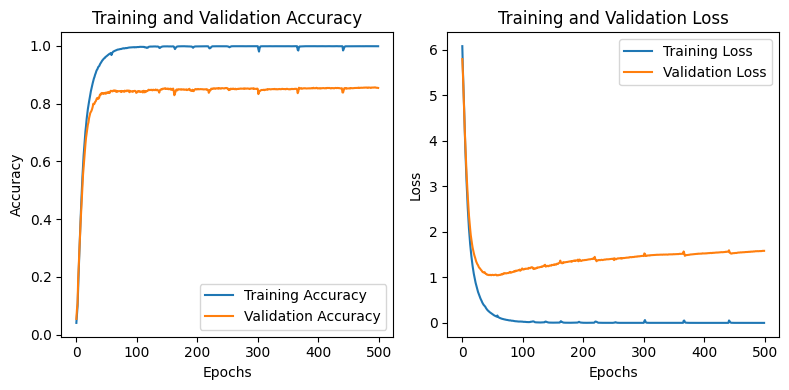

In [ ]:
plt.figure(figsize=(8, 4))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()

# Simpan gambar
plt.savefig('training_plot.png')
plt.show()


In [ ]:
# Simpan visualisasi sebagai file PNG
plt.savefig('visualisasi loss acc.png')

<Figure size 640x480 with 0 Axes>

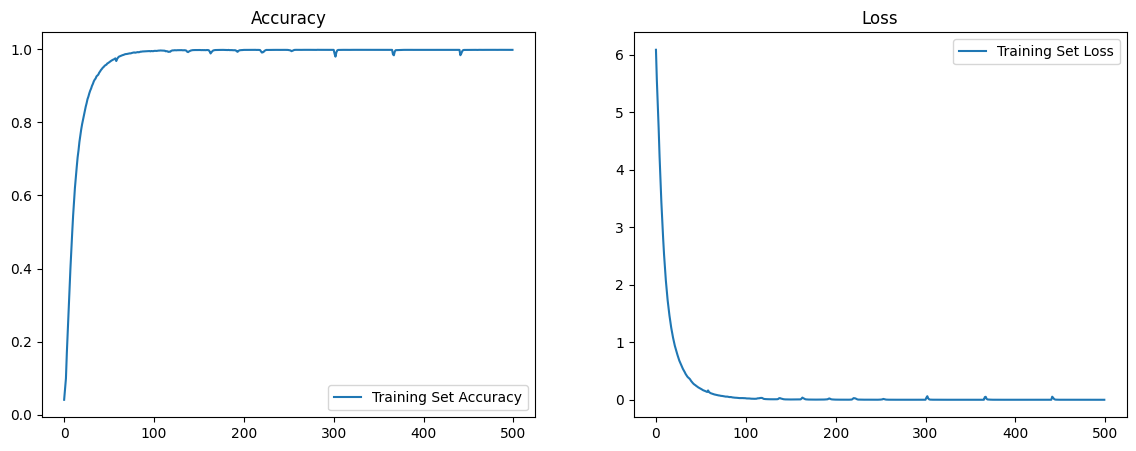

In [ ]:
#accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')


# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

###Create Inference Models

In [ ]:
def make_inference_models():
  # load biderectional lstm model with the best batch size
    bi_lstm, enc_inputs, enc_states, dec_inputs, dec_embedding, dec_lstm, dec_dense = build_bi_lstm()
    batch_size = batch_sizes[np.argmax(bi_lstm_acc)]
    bi_lstm.load_weights(f'./bi_lstm_{batch_size}.h5')
    # decoder model
    dec_state_input_h = Input(shape=(HIDDEN_DIM * 2,))
    dec_state_input_c = Input(shape=(HIDDEN_DIM * 2,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    dec_outputs, state_h, state_c = dec_lstm(dec_embedding,
                                    initial_state=dec_states_inputs)
    dec_states = [state_h, state_c]
    dec_outputs = dec_dense(dec_outputs)
    dec_model = Model(
        inputs=[dec_inputs] + dec_states_inputs,
        outputs=[dec_outputs] + dec_states)
    # encoder model
    enc_model = Model(inputs=enc_inputs, outputs=enc_states)
    return enc_model, dec_model

def str_to_tokens(sentence: str):
    # convert input string to lowercase,
    # then split it by whitespaces
    words = sentence.lower().split()
    # and then convert to a sequence
    # of integers padded with zeros
    tokens_list = list()
    for current_word in words:
        result = tokenizer.word_index.get(current_word, '')
        if result != '':
            tokens_list.append(result)
    return pad_sequences([tokens_list],
                         maxlen=maxlen_questions,
                         padding='post')

In [ ]:
# create encoder/decoder models
encoder_model, decoder_model = make_inference_models()
# interact with the chatbot
while True:
    # encode the input sequence into state vectors
    input_text = input('You: ')
    if input_text == 'exit':
        break
    states_values = encoder_model.predict(str_to_tokens(input_text))
    # start with a target sequence of size 1 - word 'start'
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition:
        # feed the state vectors and 1-word target sequence
        # to the decoder to produce predictions for the next word
        dec_outputs, h, c = decoder_model.predict([empty_target_seq]+states_values)
        # sample the next word using these predictions
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])
        sampled_word = None
        # append the sampled word to the target sequence
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                if word != 'end':
                    decoded_translation += f'{word} '
                sampled_word = word
        # repeat until we generate the end-of-sequence word 'end'
        # or we hit the length of answer limit
        if sampled_word == 'end' \
                or len(decoded_translation.split()) \
                > maxlen_answers:
            stop_condition = True
        # prepare next iteration
        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        states_values = [h, c]
    print('Chatbot: '+decoded_translation)

You: siapa kamu?
1/1 [==============================] - 0s 29ms/step
Chatbot: sama dipublikasikan dipublikasikan mahasiswa memiliki malam memiliki 144 tidak memiliki nilai e dan memiliki surat penunjukkan pembimbing yang masih aktif sudah melakukan bimbingan minimal 5 kali setelah seminar proposal sudah menghadiri seminar hasil mahasiswa lain minimal 5 kali menyerahkan laporan tugas akhir sesuai kriteria dengan maksimal plagiarisme 35 serta menyerahkan laporan kepada dosen pembimbing dan dosen penguji yang dibuktikan melalui tanda tangan pada form pendaftaran seminar hasil tugas akhir 
You: kamu siapa?
1/1 [==============================] - 0s 19ms/step
Chatbot: saya adalah chatbot informasi seminar fst 
You: mengapa kamu diciptakan?
1/1 [==============================] - 0s 18ms/step
Chatbot: saya adalah program komputer yang akan membantu menjawab rasa penasaran anda seputar layanan administasi di fakultas sains dan teknologi 
You: exit


In [ ]:
# Simpan encoder model ke dalam file terpisah
encoder_model.save('encoder_model.h5')

# Simpan decoder model ke dalam file terpisah
decoder_model.save('decoder_model.h5')


###Save Model to h5

In [ ]:
from tensorflow.keras.models import Model

# Menyimpan model ke file .h5
bi_lstm.save('model_chatbot.h5')


In [ ]:
import pickle

# Simpan objek tokenizer menggunakan pickle
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)


###Evaluasi BLEU Scor

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

# Interaksi dengan chatbot
while True:
    # encode the input sequence into state vectors
    input_text = input('You: ')
    if input_text == 'exit':
        break
    reference_answer = input("Expected Answer: ")  # Tambahkan input dari pengguna sebagai jawaban referensi
    reference_answer = clean_text(reference_answer)  # Bersihkan teks jawaban referensi
    reference_answer = '<START> ' + reference_answer + ' <END>'  # Tambahkan token <START> dan <END>

    states_values = encoder_model.predict(str_to_tokens(input_text))
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition:
        dec_outputs, h, c = decoder_model.predict([empty_target_seq]+states_values)
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])
        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                if word != 'end':
                    decoded_translation += f'{word} '
                sampled_word = word
        if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
            stop_condition = True
        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        states_values = [h, c]

    decoded_translation = decoded_translation.strip()  # Hapus spasi ekstra di awal dan akhir kalimat
    bleu_score = sentence_bleu([reference_answer.split()], decoded_translation.split())
    print('Chatbot: ' + decoded_translation)
    print('BLEU Score:', bleu_score)


You: Apa yang harus saya lakukan untuk mengetahui status terkini dari surat yang diajukan?
Expected Answer: Salah satu cara adalah dengan menggunakan menu Tracking Surat di website seminar-fst.uin-suska.ac.id. Selain itu, pastikan email yang telah diinputkan sebelumnya pada proses pengajuan untuk menerima pemberitahuan.
1/1 [==============================] - 0s 19ms/step
Chatbot: salah satu cara adalah dengan menggunakan menu tracking surat di website seminar fst uin suska ac id selain itu pastikan email yang telah diinputkan sebelumnya pada prose pengajuan untuk menerima pemberitahuan
BLEU Score: 0.6471840946505604
You: exit


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# Membersihkan pertanyaan dan jawaban dari dataset
cleaned_questions, cleaned_answers = get_clean_q_and_a(all_conversations)

# Memprediksi jawaban dari pertanyaan-pertanyaan dalam dataset
predicted_answers = []
for question in cleaned_questions:
    states_values = encoder_model.predict(str_to_tokens(question))
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition:
        dec_outputs, h, c = decoder_model.predict([empty_target_seq] + states_values)
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])
        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                if word != 'end':
                    decoded_translation += f'{word} '
                sampled_word = word
        if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
            stop_condition = True
        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        states_values = [h, c]
    predicted_answers.append(decoded_translation.strip().split())

# Hitung BLEU score untuk seluruh dataset
reference_answers = [[answer.split()] for answer in cleaned_answers]
bleu_score = corpus_bleu(reference_answers, predicted_answers)

print('BLEU Score for the Entire Dataset:', bleu_score)
